In [1]:
#!/usr/bin/env python
# coding: utf-8
import pymssql
import pandas as pd
import numpy as np
import lightgbm as lgb
from outliar import outlier
from history_data import history_data
from new_data import new_data
from engineering import engineering
from Date_Process import Date_Process

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [3]:
'''##label编码
## history_data和new_data放在一起编码，防止test有未出现
from sklearn.preprocessing import LabelEncoder
def label_coding(history_data,new_data):
	assert history_data.shape[1] == new_data.shape[1]
	all_data = pd.concat([history_data,new_data],axis=0)
	for c in ['DeviceName','DeviceRegion']:##,'DeviceType','IntervalName','LineName','Phase','DeviceName_Phase']:
		lbl = LabelEncoder()
		lbl.fit(list(all_data[c].values))
		history_data[c] = lbl.transform(list(history_data[c].values))
		new_data[c] = lbl.transform(list(new_data[c].values))
	del all_data
	return history_data,new_data
## one_hot编码
from sklearn.preprocessing import OneHotEncoder
def one_hot_coding(history_data,new_data):
	assert history_data.shape[1] == new_data.shape[1]
	all_data = pd.concat([history_data,new_data],axis=0)
	enc = OneHotEncoder()
	enc.fit(all_data[['DeviceName','DeviceRegion']])##,'DeviceType','IntervalName','LineName','Phase']])
	one_hot_history_data = enc.transform(history_data[['DeviceName','DeviceRegion']])##,'DeviceType','IntervalName','LineName','Phase']])
	one_hot_new_data = enc.transform(new_data[['DeviceName','DeviceRegion']])##,'DeviceType','IntervalName','LineName','Phase']])
	del all_data
	return one_hot_history_data,one_hot_new_data

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-3-1c408721f87e>, line 24)

In [3]:
# server 数据库服务器名称或IP
# user 用户名
# password  密码
# database  数据库
conn = pymssql.connect(host="localhost",user="",password="",database="2019_6_27",charset='UTF-8') ##本地连接方式，无需密码

In [4]:
import pandas.io.sql as sql
## 注意修改数据表
db_name = 'huxiang'
TaskStartTime = sql.read_sql('select top 1 * from ' + str(db_name) + ' where PatrolTypeID = 1 order by TaskStartTime desc',conn)

In [5]:
TaskStartTime

,DeviceName,ResultStr,Data2,Data1,Data1_bak,PatrolTime,DevicePatrolDay,DevicePatrolWeek,DevicePatrolMonth,DevicePatrolTime,...,UpperLimit0,LowerLimit2,UpperLimit2,LowerLimit3,UpperLimit3,Data2_bak,taskStartDateTime,defectfinished,defectstart,abnormal_type
0,#2主变35KV穿墙套管C相本体,,25.65,29.78,,2019-06-15 20:06:23,20190615,201924,201906,2019/6/15 20:06:23,...,50,-15,55,-20,60,,2019/6/15 20:00:00,,,normal


In [6]:
TaskStartTime.columns

Index(['DeviceName', 'ResultStr', 'Data2', 'Data1', 'Data1_bak', 'PatrolTime',
       'DevicePatrolDay', 'DevicePatrolWeek', 'DevicePatrolMonth',
       'DevicePatrolTime', 'InfraredVideoImgPath', 'RadioPath', 'DeviceRegion',
       'DeviceTypeID', 'DeviceType', 'IntervalName', 'PatrolTypeID',
       'PatrolType', 'TaskStartTime', 'LineName', 'VisibleVideoImgPath',
       'VideoPath', 'Status', 'StatusExplan', 'Num', 'Unit', 'Unit2', 'TaskID',
       'Data3', 'Substation_Id', 'DeviceRegionID', 'LineID', 'IntervalID',
       'UpperLimit', 'LowerLimit', 'taskName', 'DeviceID', 'checkId',
       'MeterType', 'LowerLimit0', 'UpperLimit0', 'LowerLimit2', 'UpperLimit2',
       'LowerLimit3', 'UpperLimit3', 'Data2_bak', 'taskStartDateTime',
       'defectfinished', 'defectstart', 'abnormal_type'],
      dtype='object')

In [7]:
TaskStartTime,new_data = new_data('huxiang',conn)

2019-06-15 20:01:20


In [8]:
TaskStartTime

Timestamp('2019-06-15 20:01:20')

In [9]:
history_data = history_data('huxiang',TaskStartTime,conn)
## 去除相同的列
history_data.drop(history_data[history_data['TaskStartTime']==TaskStartTime].index,inplace=True)
history_data = history_data.reset_index(drop=True)

2019-03-17 20:01:20 2019-06-15 20:01:20


In [10]:
new_data,thre_outlier = outlier(new_data)

In [17]:
history_data.head()

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName
0,#3主变220kV侧B相套管引线T接头,28.32,29.25,2019-06-15 19:12:40,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变
1,#3主变220kV侧C相套管引线接头,28.29,39.62,2019-06-15 19:12:59,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变
2,#3主变220kV侧B相套管本体,28.22,40.33,2019-06-15 19:13:56,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变
3,#3主变220kV侧A相套管引线接头,28.20,40.01,2019-06-15 19:14:05,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变
4,#3主变220kV侧C相套管本体,28.34,39.67,2019-06-15 19:12:14,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变


In [1518]:
new_data_ = history_data['TaskStartTime'].value_counts().index
new_data_ = new_data_.sort_values(ascending=False)

new_data_.shape

k = new_data_[62]
new_data = history_data.loc[history_data['TaskStartTime']==k,:]
new_data,thre_outlier = outlier(new_data)

G:\infrared\outliar.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Data1'] = data['Data1'].astype('float32')
G:\infrared\outliar.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['Data2'] = data['Data2'].astype('float32')
G:\infrared\outliar.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data['D

In [1519]:
'''history_data,thre_outlier_history = outlier(history_data)
thre_outlier'''

'history_data,thre_outlier_history = outlier(history_data)\nthre_outlier'

In [1520]:
PatrolTime0 = thre_outlier['PatrolTime'].values.tolist()

### 向数据库中插入异常类型
cur = conn.cursor()
##cur.execute("insert into huxiang（'abnormal_type') values ('阈值异常');")

for i in PatrolTime0:
    sSQL = "update huxiang set abnormal_type='threshold' where PatrolTime=" + "'"+str(i)+"'"
    cur.execute(sSQL)
    conn.commit()
    print(sSQL)

update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-06 22:47:11'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-06 20:43:21'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-06 23:59:38'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-07 00:00:38'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-07 00:02:34'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-07 00:44:00'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-07 01:33:45'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-07 02:04:01'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-06 22:42:45'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-07 00:54:26'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-06 23:58:43'
update huxiang set abnormal_type='threshold' where PatrolTime='2019-04-06 20

### 绘图

In [1469]:
history_data.head()

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase
0,#3主变220kV侧B相套管引线T接头,28.32,29.25,2019-06-15 19:12:40,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,B相,#3主变220kV侧套管引线T接头
1,#3主变220kV侧C相套管引线接头,28.29,39.62,2019-06-15 19:12:59,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,C相,#3主变220kV侧套管引线接头
2,#3主变220kV侧B相套管本体,28.22,40.33,2019-06-15 19:13:56,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,B相,#3主变220kV侧套管本体
3,#3主变220kV侧A相套管引线接头,28.20,40.01,2019-06-15 19:14:05,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,A相,#3主变220kV侧套管引线接头
4,#3主变220kV侧C相套管本体,28.34,39.67,2019-06-15 19:12:14,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,C相,#3主变220kV侧套管本体


In [1322]:
new_data.head()

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase
0,象中2464线避雷器B相引下线T接头,15.92,16.139999,2019-04-14 03:21:28,220KV区域,断路器,象中2464线避雷器,2019-04-13 20:01:35,象中2464,B相,象中2464线避雷器引下线T接头
1,虎中2465线线路闸刀A相本体（侧面）,15.94,16.820000,2019-04-14 03:23:10,220KV区域,断路器,虎中2465线线路闸刀,2019-04-13 20:01:35,虎中2465,A相,虎中2465线线路闸刀本体（侧面）
2,虎中2465线线路闸刀C相本体（侧面）,15.95,17.049999,2019-04-14 03:25:07,220KV区域,断路器,虎中2465线线路闸刀,2019-04-13 20:01:35,虎中2465,C相,虎中2465线线路闸刀本体（侧面）
3,虎中2465线避雷器B相引下线T接头,15.94,15.810000,2019-04-14 03:26:57,220KV区域,断路器,虎中2465线避雷器,2019-04-13 20:01:35,虎中2465,B相,虎中2465线避雷器引下线T接头
4,象中2464线避雷器B相本体（正面）,15.95,16.200001,2019-04-14 03:20:36,220KV区域,断路器,象中2464线避雷器,2019-04-13 20:01:35,象中2464,B相,象中2464线避雷器本体（正面）


In [929]:
all_data = pd.concat([history_data,new_data],axis=0,ignore_index=True)

In [930]:
all_data.head()

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase
0,#3主变220kV侧B相套管引线T接头,28.32,29.25,2019-06-15 19:12:40,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,B相,#3主变220kV侧套管引线T接头
1,#3主变220kV侧C相套管引线接头,28.29,39.62,2019-06-15 19:12:59,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,C相,#3主变220kV侧套管引线接头
2,#3主变220kV侧B相套管本体,28.22,40.33,2019-06-15 19:13:56,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,B相,#3主变220kV侧套管本体
3,#3主变220kV侧A相套管引线接头,28.20,40.01,2019-06-15 19:14:05,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,A相,#3主变220kV侧套管引线接头
4,#3主变220kV侧C相套管本体,28.34,39.67,2019-06-15 19:12:14,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,C相,#3主变220kV侧套管本体


In [47]:
OneDevice = all_data.loc[all_data['DeviceName'] == '#3主变220kV侧C相套管本体',:] 

In [48]:
OneDevice

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase
4,#3主变220kV侧C相套管本体,28.34,39.67,2019-06-15 19:12:14,主变区域,断路器,#3主变220kV侧套管,2019-06-15 19:01:19,#3主变,C相,#3主变220kV侧套管本体
224,#3主变220kV侧C相套管本体,20.48,26.77,2019-06-14 21:46:25,主变区域,断路器,#3主变220kV侧套管,2019-06-14 20:01:23,#3主变,C相,#3主变220kV侧套管本体
235,#3主变220kV侧C相套管本体,22.84,33.41,2019-06-14 19:11:22,主变区域,断路器,#3主变220kV侧套管,2019-06-14 19:01:18,#3主变,C相,#3主变220kV侧套管本体
245,#3主变220kV侧C相套管本体,17.75,18.60,2019-06-13 21:52:53,主变区域,断路器,#3主变220kV侧套管,2019-06-13 20:01:23,#3主变,C相,#3主变220kV侧套管本体
464,#3主变220kV侧C相套管本体,18.94,23.56,2019-06-13 19:11:16,主变区域,断路器,#3主变220kV侧套管,2019-06-13 19:01:17,#3主变,C相,#3主变220kV侧套管本体
686,#3主变220kV侧C相套管本体,22.95,28.73,2019-06-12 21:47:54,主变区域,断路器,#3主变220kV侧套管,2019-06-12 20:01:16,#3主变,C相,#3主变220kV侧套管本体
700,#3主变220kV侧C相套管本体,23.98,31.74,2019-06-12 19:11:43,主变区域,断路器,#3主变220kV侧套管,2019-06-12 19:01:19,#3主变,C相,#3主变220kV侧套管本体
739,#3主变220kV侧C相套管本体,23.89,30.11,2019-06-11 21:55:45,主变区域,断路器,#3主变220kV侧套管,2019-06-11 20:01:18,#3主变,C相,#3主变220kV侧套管本体
934,#3主变220kV侧C相套管本体,25.77,35.71,2019-06-11 19:12:20,主变区域,断路器,#3主变220kV侧套管,2019-06-11 19:01:22,#3主变,C相,#3主变220kV侧套管本体
1153,#3主变220kV侧C相套管本体,24.42,29.16,2019-06-10 21:44:47,主变区域,断路器,#3主变220kV侧套管,2019-06-10 20:01:19,#3主变,C相,#3主变220kV侧套管本体


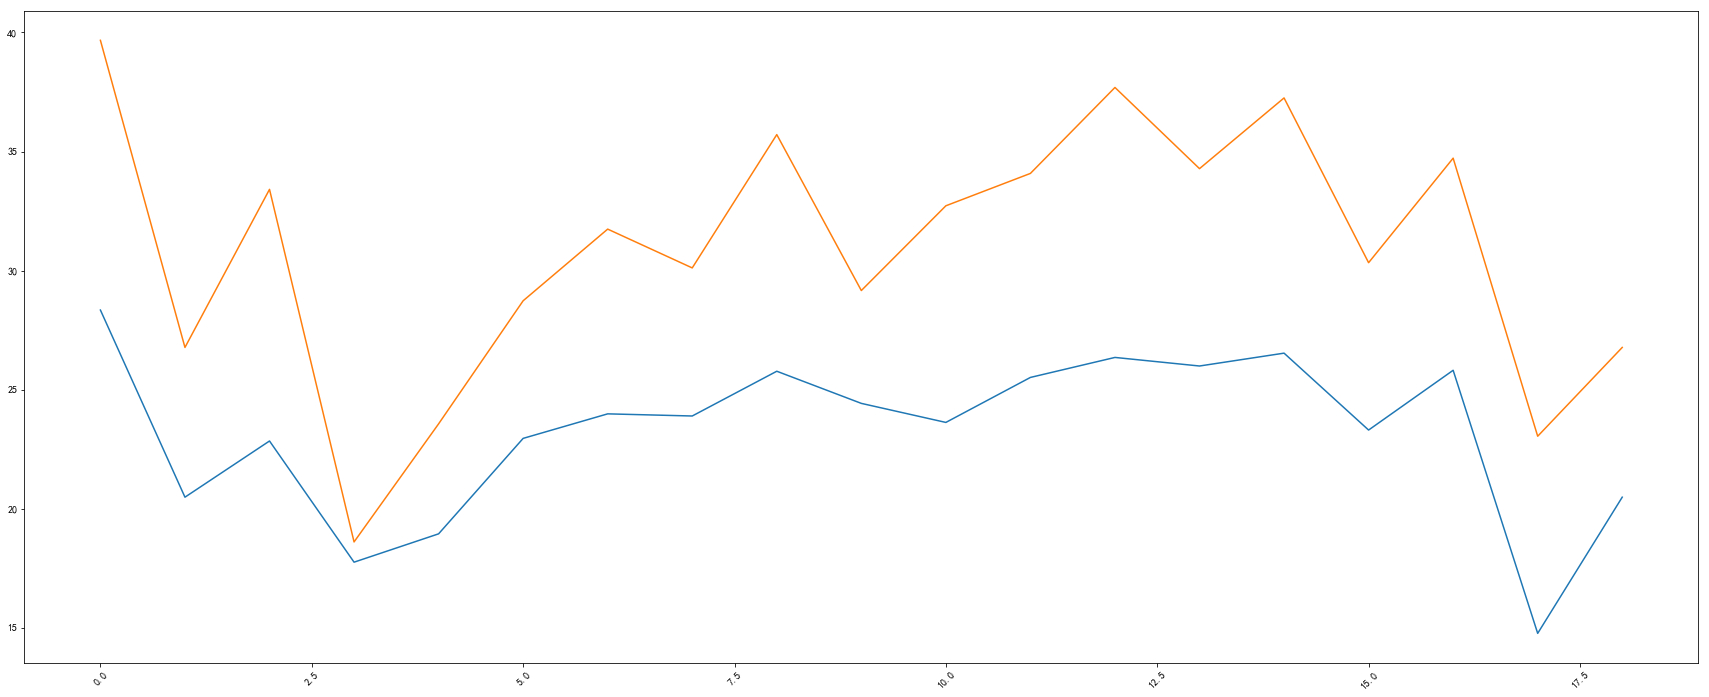

In [49]:
plt.figure(figsize=(30,12))
plt.xticks(rotation=45)
plt.plot(OneDevice['Data2'].values)
plt.plot(OneDevice['Data1'].values)

### 四分位法寻找异常值（规则设计）

In [1521]:
## 三相特征
new_data = engineering(new_data)
history_data = engineering(history_data)

In [1522]:
new_data

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase
0,220kV正母母线绝缘子A相18,22.940001,25.600000,2019-04-06 20:07:06,220KV区域,母线及绝缘子,220kV正母母线绝缘子,2019-04-06 20:01:35,220kV正母,A相,220kV正母母线绝缘子18
1,110KV#1母联开关C相本体及下侧接头,22.900000,12.090000,2019-04-06 20:08:39,220KV区域,断路器,#1主变220KV正母闸刀,2019-04-06 20:01:35,#1主变220KV,C相,110KV#1母联开关本体及下侧接头
2,桃虎2U39正母闸刀B相引下线T接头,22.820000,23.820000,2019-04-06 20:14:12,220KV区域,断路器,桃虎2U39正母闸刀,2019-04-06 20:01:35,桃虎2U39,B相,桃虎2U39正母闸刀引下线T接头
3,220kV正母母线绝缘子A相16,22.830000,25.200001,2019-04-06 20:15:09,220KV区域,母线及绝缘子,220kV正母母线绝缘子,2019-04-06 20:01:35,220kV正母,A相,220kV正母母线绝缘子16
4,220kV正母母线绝缘子B相16,22.809999,25.280001,2019-04-06 20:15:20,220KV区域,母线及绝缘子,220kV正母母线绝缘子,2019-04-06 20:01:35,220kV正母,B相,220kV正母母线绝缘子16
5,220kV正母母线绝缘子C相16,22.820000,23.620001,2019-04-06 20:15:36,220KV区域,母线及绝缘子,220kV正母母线绝缘子,2019-04-06 20:01:35,220kV正母,C相,220kV正母母线绝缘子16
6,220kV正母母线绝缘子A相17,22.809999,25.400000,2019-04-06 20:15:51,220KV区域,母线及绝缘子,220kV正母母线绝缘子,2019-04-06 20:01:35,220kV正母,A相,220kV正母母线绝缘子17
7,220kV正母母线绝缘子B相17,22.820000,25.180000,2019-04-06 20:16:09,220KV区域,母线及绝缘子,220kV正母母线绝缘子,2019-04-06 20:01:35,220kV正母,B相,220kV正母母线绝缘子17
8,#2主变220KV正母闸刀A相引下线T接头,22.860001,23.770000,2019-04-06 20:17:27,220KV区域,断路器,#2主变220KV正母闸刀,2019-04-06 20:01:35,#2主变220KV,A相,#2主变220KV正母闸刀引下线T接头
9,#2主变220KV避雷器A相本体（正面）,22.840000,26.049999,2019-04-06 20:18:24,220KV区域,断路器,#2主变220KV避雷器,2019-04-06 20:01:35,#2主变220KV,A相,#2主变220KV避雷器本体（正面）


#### 三相异常

In [1523]:
DeviceName_Phase_Num = new_data['DeviceName_Phase'].value_counts()
new_data['DeviceName_Phase_Num'] = new_data['DeviceName_Phase'].map(lambda x:DeviceName_Phase_Num[x])

In [1524]:
new_data_phase = new_data.loc[new_data['DeviceName_Phase_Num']==3 

SyntaxError: unexpected EOF while parsing (<ipython-input-1524-a32de37ad4ea>, line 1)

In [ ]:
del new_data['DeviceName_Phase_Num']

In [ ]:
Phase_Data1_median = new_data_phase.groupby(['DeviceName_Phase'])['Data1'].median()

In [ ]:
new_data_phase['Phase_Data1_median'] = new_data_phase['DeviceName_Phase'].map(lambda x:Phase_Data1_median[x])  

In [ ]:
new_data_phase['Phase_Data1_diff'] = new_data_phase['Data1'] - new_data_phase['Phase_Data1_median']

In [ ]:
new_data_phase

In [ ]:
## 去掉中值
new_data_phase1 = new_data_phase.loc[new_data_phase['Phase_Data1_diff']!=0.00,:]

In [ ]:
fin_outlier0 = []
diff = new_data_phase1['Phase_Data1_diff'].values
print(diff)
##diff_sort = Sort(diff)
##print(diff_sort)
q20, q80 = np.percentile(diff,20), np.percentile(diff,80)
iqr = q80 - q20
print(q20,q80)
# calculate the outlier cutoff
cut_off = iqr * 1.0
lower, upper = q20 - cut_off, q80 + cut_off
print(lower,upper)
# identify outlier
for i in diff:
    if i < lower or i > upper:
        fin_outlier0.append(new_data_phase1.loc[new_data_phase1['Phase_Data1_diff'] == i,:].index.tolist())

In [ ]:
plt.scatter(diff,diff)

In [ ]:
outlier_phase = []
for i in range(len(fin_outlier0)):
    outlier_phase.append(fin_outlier0[i][0])

In [ ]:
outlier_phase

In [ ]:
phase_outlier = new_data.loc[outlier_phase,:]

In [ ]:
PatrolTime1 = phase_outlier['PatrolTime'].values.tolist()

### 向数据库中插入异常类型
cur = conn.cursor()

for i in PatrolTime1:
    sSQL = "update huxiang set abnormal_type='phase' where PatrolTime=" + "'"+str(i)+"'"
    cur.execute(sSQL)
    conn.commit()
    print(sSQL)

## LineName异常

#### 红外值异常

In [ ]:
new_data.head(2)

In [ ]:
## 利用差值分布甄选异常值
## 四分位法
LineName = new_data['LineName'].value_counts().index.tolist()
outlier_quarter = []
for i in LineName:
    tmp = new_data[new_data['LineName']==i]
    ## err是1D，np.array()
    diff = (tmp['Data1'] - tmp['Data2']).values
    print(diff)
    ##print(diff.sort())
    q25, q75 = np.percentile(diff,25), np.percentile(diff,75)
    iqr = q75 - q25
    #print(q25,q75)
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    ##print(lower,upper)
    # identify outlier
    for i,x in enumerate(diff):
        if x < lower or  x > upper:
            outlier_quarter.append(i)
    ##outliers_removed = [x for x in data if x > lower and x < upper]

In [ ]:
import seaborn as sns
sns.violinplot(x='LineName',y='Data1',data=new_data)

In [ ]:
stat_outlier = new_data.loc[outlier_quarter,:]

In [ ]:
PatrolTime2 = stat_outlier['PatrolTime'].values.tolist()

### 向数据库中插入异常类型
cur = conn.cursor()

for i in PatrolTime2:
    sSQL = "update huxiang set abnormal_type='phase' where PatrolTime=" + "'"+str(i)+"'"
    cur.execute(sSQL)
    conn.commit()
    print(sSQL)

### 历史数据比较(2次)  
为了保证比较的可靠，历史数据必须可靠，剔除异常的数据，先做三相异常和Linename异常,然后再比较。

### 特征工程

In [29]:
### 三相平滑

In [ ]:
DeviceName_Phase_Num = history_data.groupby(['TaskStartTime','DeviceName_Phase'])['DeviceName_Phase'].count()

In [45]:
DeviceName_Phase_Num = pd.DataFrame(DeviceName_Phase_Num)

In [53]:
DeviceName_Phase_Num.columns = ['Phase_Num']

In [57]:
DeviceName_Phase_Num = DeviceName_Phase_Num.reset_index()

In [58]:
history_data = history_data.merge(DeviceName_Phase_Num,how='left',on=['TaskStartTime','DeviceName_Phase'])

In [61]:
history_data_phase_median = history_data.loc[history_data['Phase_Num']==3,['TaskStartTime','DeviceName_Phase','Data1']]

In [64]:
history_data_phase_median = history_data_phase_median.groupby(['TaskStartTime','DeviceName_Phase'])['Data1'].median()

In [66]:
history_data_phase_median = pd.DataFrame(history_data_phase_median)

In [70]:
history_data_phase_median.columns = ['Phase_Data1']

In [73]:
history_data_phase_median = history_data_phase_median.reset_index()

In [75]:
history_data = history_data.merge(history_data_phase_median,how='left',on=['TaskStartTime','DeviceName_Phase'])

In [78]:
Phase_Data1 = history_data['Phase_Data1']

In [83]:
history_data.loc[history_data['Phase_Data1'].isnull(),'Phase_Data1'] = history_data['Data1']

In [84]:
history_data['Data1'] = history_data['Phase_Data1']

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase,Phase_Num,Phase_Data1
0,#1主变压器10kV避雷器B相本体(侧面),16.920000,17.622940,2019-03-29 23:05:27,主变区域,避雷器,#1主变压器10kV避雷器,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器10kV避雷器本体(侧面),3,17.622940
1,#1主变110kV变压器闸刀C相本体(正面),17.110001,15.397730,2019-03-29 20:00:50,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀本体(正面),3,15.397730
2,#1主变110kV变压器闸刀C相母线侧引线接头,17.120001,15.593180,2019-03-29 20:01:21,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀母线侧引线接头,3,15.593180
3,110kV1号母线A相支持瓷瓶1,17.100000,18.385820,2019-03-29 20:01:47,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,A相,110kV1号母线支持瓷瓶1,3,18.385820
4,110kV1号母线B相支持瓷瓶2,17.120001,16.162760,2019-03-29 20:02:15,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,B相,110kV1号母线支持瓷瓶2,3,16.162760
5,110kV1号母线C相支持瓷瓶2,17.129999,15.671130,2019-03-29 20:02:49,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,C相,110kV1号母线支持瓷瓶2,3,15.671130
6,#1主变压器110kV侧套管B相瓷瓶,17.139999,22.465010,2019-03-29 20:03:33,主变区域,主变（电抗器）,#1主变压器110kV侧套管,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器110kV侧套管瓷瓶,2,NaN
7,#1主变压器110kV侧套管B相引流线,17.150000,16.482000,2019-03-29 20:03:46,主变区域,主变（电抗器）,#1主变压器110kV侧套管,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器110kV侧套管引流线,3,16.482000
8,#1主变压器110kV侧套管C相T接头,17.180000,19.655149,2019-03-29 20:04:12,主变区域,主变（电抗器）,#1主变压器110kV侧套管,2019-03-29 20:00:06,#1主变压器,C相,#1主变压器110kV侧套管T接头,3,19.655149
9,#1主变110kV变压器闸刀C相导电臂及触头（正面）,17.110001,15.400990,2019-03-29 20:01:05,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀导电臂及触头（正面）,1,NaN


In [ ]:
del history_data['Phase_Num','Phase_Data1']

In [35]:
## 时间特征
Date_Pro = Date_Process()
all_data = pd.concat([new_data,history_data],axis=0)
all_data = Date_Pro.time_eda(all_data)
all_data = Date_Pro.ranks_fit_transform(all_data)
##history_data = all_data.loc[:all_data.shape[0]]
##new_data = all_data.loc[all_data.shape[0]:]"

In [36]:
new_data = all_data[:new_data.shape[0]]
history_data = all_data[new_data.shape[0]:]

In [37]:
new_data.head()

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase,year,month,day,hour,day_of_week,ranks
0,#1主变110kV变压器闸刀C相导电臂及触头（正面）,16.930000,15.903450,2019-03-30 20:01:11,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-30 20:00:11,#1主变110kV变压器,C相,#1主变110kV变压器闸刀导电臂及触头（正面）,2019,3,30,20,5,6
1,#1主变110kV变压器闸刀C相主变侧引线接头,16.969999,16.403231,2019-03-30 20:01:41,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-30 20:00:11,#1主变110kV变压器,C相,#1主变110kV变压器闸刀主变侧引线接头,2019,3,30,20,5,6
2,110kV1号母线B相支持瓷瓶1,17.000000,19.095631,2019-03-30 20:02:13,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-30 20:00:11,110kV1号母线,B相,110kV1号母线支持瓷瓶1,2019,3,30,20,5,6
3,110kV1号母线C相支持瓷瓶1,17.020000,18.948080,2019-03-30 20:02:42,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-30 20:00:11,110kV1号母线,C相,110kV1号母线支持瓷瓶1,2019,3,30,20,5,6
4,110kV1号母线C相支持瓷瓶3,17.059999,16.680490,2019-03-30 20:03:17,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-30 20:00:11,110kV1号母线,C相,110kV1号母线支持瓷瓶3,2019,3,30,20,5,6


In [38]:
history_data.head()

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase,year,month,day,hour,day_of_week,ranks
0,#1主变压器10kV避雷器B相本体(侧面),16.920000,17.62294,2019-03-29 23:05:27,主变区域,避雷器,#1主变压器10kV避雷器,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器10kV避雷器本体(侧面),2019,3,29,20,4,5
1,#1主变110kV变压器闸刀C相本体(正面),17.110001,15.39773,2019-03-29 20:00:50,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀本体(正面),2019,3,29,20,4,5
2,#1主变110kV变压器闸刀C相母线侧引线接头,17.120001,15.59318,2019-03-29 20:01:21,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀母线侧引线接头,2019,3,29,20,4,5
3,110kV1号母线A相支持瓷瓶1,17.100000,18.38582,2019-03-29 20:01:47,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,A相,110kV1号母线支持瓷瓶1,2019,3,29,20,4,5
4,110kV1号母线B相支持瓷瓶2,17.120001,16.16276,2019-03-29 20:02:15,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,B相,110kV1号母线支持瓷瓶2,2019,3,29,20,4,5


target encoding(目标编码)

In [39]:
def groupby(df,col1,col2,agg_way):
    agg = df.groupby(col1)[col2].agg(agg_way)
    agg = pd.DataFrame(agg)
    ##print(agg)
    col1_ = ''
    for i in col1:
        col1_ = col1_ + '_' + str(i)  
    agg = agg.add_suffix(col1_+'_'+agg_way)
    df = df.merge(agg,left_on=col1,right_index=True,how='left')
    return df

In [40]:
def groupby_quantile(df,col1,col2,qua):
    agg = df.groupby(col1)[col2].quantile(qua)
    agg = pd.DataFrame(agg)
    ##print(agg)
    col1_ = ''
    for i in col1:
        col1_ = col1_ + '_' + str(i)  
    agg = agg.add_suffix(col1_+'_'+str(qua))
    df = df.merge(agg,left_on=col1,right_index=True,how='left')
    return df

In [41]:
history_data.columns

Index(['DeviceName', 'Data2', 'Data1', 'PatrolTime', 'DeviceRegion',
       'DeviceType', 'IntervalName', 'TaskStartTime', 'LineName', 'Phase',
       'DeviceName_Phase', 'year', 'month', 'day', 'hour', 'day_of_week',
       'ranks'],
      dtype='object')

In [42]:
history_data.nunique()

DeviceName           443
Data2                423
Data1               2483
PatrolTime          2568
DeviceRegion           2
DeviceType             9
IntervalName          41
TaskStartTime          7
LineName              11
Phase                  4
DeviceName_Phase     181
year                   1
month                  1
day                    6
hour                   2
day_of_week            6
ranks                  6
dtype: int64

In [43]:
## 基于TaskStartTime和DeviceRegion
history_data = groupby_quantile(history_data,['TaskStartTime','DeviceRegion'],'Data1',0.5)
history_data = groupby(history_data,['TaskStartTime','DeviceRegion'],'Data1','std')
## 基于TaskStartTime,IntervalName
##history_data = groupby_quantile(history_data,['TaskStartTime','IntervalName'],'Data1',0.5)
##history_data = groupby(history_data,['TaskStartTime','IntervalName'],'Data1','std')
## 基于TaskStartTime,DeviceRegion和DeviceType
##history_data = groupby_quantile(history_data,['TaskStartTime','DeviceRegion','DeviceType'],'Data1',0.5)
##history_data = groupby(history_data,['TaskStartTime','DeviceRegion','DeviceType'],'Data1','std')
## 基于TaskStartTime和DeviceName_Phase
##history_data = groupby_quantile(history_data,['TaskStartTime','DeviceName_Phase'],'Data1',0.5)
##history_data = groupby(history_data,['TaskStartTime','DeviceName_Phase'],'Data1','std')
## 基于TaskStartTime和LineName
##history_data = groupby_quantile(history_data,['TaskStartTime','LineName'],'Data1',0.5)
##history_data = groupby(history_data,['TaskStartTime','LineName'],'Data1','std')

In [44]:
history_data.columns

Index(['DeviceName', 'Data2', 'Data1', 'PatrolTime', 'DeviceRegion',
       'DeviceType', 'IntervalName', 'TaskStartTime', 'LineName', 'Phase',
       'DeviceName_Phase', 'year', 'month', 'day', 'hour', 'day_of_week',
       'ranks', 'Data1_TaskStartTime_DeviceRegion_0.5',
       'Data1_TaskStartTime_DeviceRegion_std'],
      dtype='object')

In [45]:
'''target_col = ['Data1_TaskStartTime_DeviceRegion_0.5','Data1_TaskStartTime_DeviceRegion_std','Data1_TaskStartTime_IntervalName_0.5',
'Data1_TaskStartTime_IntervalName_std','Data1_TaskStartTime_DeviceRegion_DeviceType_0.5','Data1_TaskStartTime_DeviceRegion_DeviceType_std',
'Data1_TaskStartTime_DeviceName_Phase_0.5','Data1_TaskStartTime_DeviceName_Phase_std','Data1_TaskStartTime_LineName_0.5', 'Data1_TaskStartTime_LineName_std']''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-45-2a1b76876723>, line 3)

In [46]:
'''for i in target_col:
    new_data.loc[i,:] = np.nan'''

'for i in target_col:\n    new_data.loc[i,:] = np.nan'

In [47]:
'''history_data.drop(['PatrolTime','TaskStartTime'],axis=1,inplace=True)'''

"history_data.drop(['PatrolTime','TaskStartTime'],axis=1,inplace=True)"

In [48]:
'''new_data.drop(['PatrolTime','TaskStartTime'],axis=1,inplace=True)'''

"new_data.drop(['PatrolTime','TaskStartTime'],axis=1,inplace=True)"

one_hot和label编码

In [49]:
'''history_data,new_data = label_coding(history_data,new_data)
one_hot_history_data,one_hot_new_data = one_hot_coding(history_data,new_data)
## 将稀疏矩阵转成正常矩阵
one_hot_history_data = one_hot_history_data.toarray()
one_hot_new_data = one_hot_new_data.toarray()

## 稀疏矩阵之间合并会报错
history_data = np.concatenate([history_data.values,one_hot_history_data],axis=1)
new_data = np.concatenate([new_data.values,one_hot_new_data],axis=1)'''

'history_data,new_data = label_coding(history_data,new_data)\none_hot_history_data,one_hot_new_data = one_hot_coding(history_data,new_data)\n## 将稀疏矩阵转成正常矩阵\none_hot_history_data = one_hot_history_data.toarray()\none_hot_new_data = one_hot_new_data.toarray()\n\n## 稀疏矩阵之间合并会报错\nhistory_data = np.concatenate([history_data.values,one_hot_history_data],axis=1)\nnew_data = np.concatenate([new_data.values,one_hot_new_data],axis=1)'

In [50]:
history_data

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName,Phase,DeviceName_Phase,year,month,day,hour,day_of_week,ranks,Data1_TaskStartTime_DeviceRegion_0.5,Data1_TaskStartTime_DeviceRegion_std
0,#1主变压器10kV避雷器B相本体(侧面),16.920000,17.622940,2019-03-29 23:05:27,主变区域,避雷器,#1主变压器10kV避雷器,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器10kV避雷器本体(侧面),2019,3,29,20,4,5,19.033710,2.414067
1,#1主变110kV变压器闸刀C相本体(正面),17.110001,15.397730,2019-03-29 20:00:50,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀本体(正面),2019,3,29,20,4,5,16.509660,1.744370
2,#1主变110kV变压器闸刀C相母线侧引线接头,17.120001,15.593180,2019-03-29 20:01:21,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀母线侧引线接头,2019,3,29,20,4,5,16.509660,1.744370
3,110kV1号母线A相支持瓷瓶1,17.100000,18.385820,2019-03-29 20:01:47,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,A相,110kV1号母线支持瓷瓶1,2019,3,29,20,4,5,16.509660,1.744370
4,110kV1号母线B相支持瓷瓶2,17.120001,16.162760,2019-03-29 20:02:15,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,B相,110kV1号母线支持瓷瓶2,2019,3,29,20,4,5,16.509660,1.744370
5,110kV1号母线C相支持瓷瓶2,17.129999,15.671130,2019-03-29 20:02:49,110kV区域,母线及绝缘子,110kV1号母线支持瓷瓶,2019-03-29 20:00:06,110kV1号母线,C相,110kV1号母线支持瓷瓶2,2019,3,29,20,4,5,16.509660,1.744370
6,#1主变压器110kV侧套管B相瓷瓶,17.139999,22.465010,2019-03-29 20:03:33,主变区域,主变（电抗器）,#1主变压器110kV侧套管,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器110kV侧套管瓷瓶,2019,3,29,20,4,5,19.033710,2.414067
7,#1主变压器110kV侧套管B相引流线,17.150000,16.482000,2019-03-29 20:03:46,主变区域,主变（电抗器）,#1主变压器110kV侧套管,2019-03-29 20:00:06,#1主变压器,B相,#1主变压器110kV侧套管引流线,2019,3,29,20,4,5,19.033710,2.414067
8,#1主变压器110kV侧套管C相T接头,17.180000,19.655149,2019-03-29 20:04:12,主变区域,主变（电抗器）,#1主变压器110kV侧套管,2019-03-29 20:00:06,#1主变压器,C相,#1主变压器110kV侧套管T接头,2019,3,29,20,4,5,19.033710,2.414067
9,#1主变110kV变压器闸刀C相导电臂及触头（正面）,17.110001,15.400990,2019-03-29 20:01:05,110kV区域,隔离开关,#1主变110kV变压器闸刀,2019-03-29 20:00:06,#1主变110kV变压器,C相,#1主变110kV变压器闸刀导电臂及触头（正面）,2019,3,29,20,4,5,16.509660,1.744370


### LGB

In [51]:
x_train = history_data
x_test = new_data
## y_train,x_test在上面

In [52]:
x_test.shape

(421, 17)

In [53]:
params = {
'task': 'train',
'boosting_type': 'gbdt',
'objective': 'regression',
'metric': 'mean_squared_error',
'num_leaves': 20,
'max_depth':3,
'learning_rate':0.2,
'feature_fraction': 0.95,
'bagging_fraction': 0.85,
##'bagging_freq': , 
'verbose': 0}

In [54]:
def groupby_cv(df,col1,col2,agg_way):
    agg = df.groupby(col1)[col2].agg(agg_way)
    agg = pd.DataFrame(agg)
    ##print(agg)
    col1_ = ''
    for i in col1:
        col1_ = col1_ + '_' + str(i)  
    agg = agg.add_suffix(col1_+'_'+agg_way)
    return agg

In [55]:
def groupby_quantile_cv(df,col1,col2,qua):
    agg = df.groupby(col1)[col2].quantile(qua)
    agg = pd.DataFrame(agg)
    ##print(agg)
    col1_ = ''
    for i in col1:
        col1_ = col1_ + '_' + str(i)  
    agg = agg.add_suffix(col1_+'_'+str(qua))
    ##df = df.merge(agg,left_on=col1,right_index=True,how='left')
    return agg

In [56]:
import lightgbm as lgb
from sklearn.model_selection import KFold

In [61]:
x_test.shape

(421, 17)

In [58]:
from sklearn.metrics import mean_squared_error

In [62]:
folds = KFold(n_splits=10,shuffle=True,random_state=42)

cv_pred = np.zeros(x_test.shape[0])
for fold_n, (train_index, test_index) in enumerate(folds.split(x_test)):
    print('Fold', fold_n)
    X_train_, X_test = x_test.loc[train_index,:], x_test.loc[test_index,:]
    ## 基于TaskStartTime和DeviceRegion
    agg = groupby_quantile_cv(X_train_,['TaskStartTime','DeviceRegion'],'Data1',0.5)
    X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','DeviceRegion'],right_index=True,how='left')
    X_test = X_test.merge(agg,left_on=['TaskStartTime','DeviceRegion'],right_index=True,how='left')
    agg = groupby_cv(X_train_,['TaskStartTime','DeviceRegion'],'Data1','std')
    X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','DeviceRegion'],right_index=True,how='left')
    X_test = X_test.merge(agg,left_on=['TaskStartTime','DeviceRegion'],right_index=True,how='left')
    ## 基于TaskStartTime,IntervalName
    ##agg = groupby_quantile_cv(X_train_,['TaskStartTime','IntervalName'],'Data1',0.5)
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','IntervalName'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','IntervalName'],right_index=True,how='left')
    ##agg = groupby_cv(X_train_,['TaskStartTime','IntervalName'],'Data1','std')
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','IntervalName'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','IntervalName'],right_index=True,how='left')
    ## 基于TaskStartTime,DeviceRegion和DeviceType
    ##agg = groupby_quantile_cv(X_train_,['TaskStartTime','DeviceRegion','DeviceType'],'Data1',0.5)
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','DeviceRegion','DeviceType'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','DeviceRegion','DeviceType'],right_index=True,how='left')
    ##agg = groupby_cv(X_train_,['TaskStartTime','DeviceRegion','DeviceType'],'Data1','std')
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','DeviceRegion','DeviceType'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','DeviceRegion','DeviceType'],right_index=True,how='left')
    ## 基于TaskStartTime和DeviceName_Phase
    ##agg = groupby_quantile_cv(X_train_,['TaskStartTime','DeviceName_Phase'],'Data1',0.5)
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','DeviceName_Phase'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','DeviceName_Phase'],right_index=True,how='left')
    ##agg = groupby_cv(X_trai  n_,['TaskStartTime','DeviceName_Phase'],'Data1','std')
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','DeviceName_Phase'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','DeceName_Phase'],right_index=True,how='left')
    ## 基于TaskStartTime和LineName
    ##agg = groupby_quantile_cv(X_train_,['TaskStartTime','LineName'],'Data1',0.5)
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','LineName'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','LineName'],right_index=True,how='left')
    ##agg = groupby_cv(X_train_,['TaskStartTime','LineName'],'Data1','std')
    ##X_train_ = X_train_.merge(agg,left_on=['TaskStartTime','LineName'],right_index=True,how='left')
    ##X_test = X_test.merge(agg,left_on=['TaskStartTime','LineName'],right_index=True,how='left')
       
    X_train = pd.concat([x_train,X_train_],axis=0)
    
    ## 分离标签和数据
    y_train = X_train['Data1']
    X_train.drop('Data1',axis=1,inplace=True)
    y_test = X_test['Data1']
    X_test.drop('Data1',axis=1,inplace=True)
    
    X_train.drop(['PatrolTime','TaskStartTime'],axis=1,inplace=True)
    X_test.drop(['PatrolTime','TaskStartTime'],axis=1,inplace=True)
    X_train.drop(['DeviceType','IntervalName','LineName','Phase','DeviceName_Phase'],axis=1,inplace=True)
    X_test.drop(['DeviceType','IntervalName','LineName','Phase','DeviceName_Phase'],axis=1,inplace=True)
    
    X_train,X_test = label_coding(X_train,X_test)
    one_hot_history_data,one_hot_new_data = one_hot_coding(X_train,X_test)
    ## 将稀疏矩阵转成正常矩阵
    one_hot_history_data = one_hot_history_data.toarray()
    one_hot_new_data = one_hot_new_data.toarray()

    ## 稀疏矩阵之间合并会报错
    X_train = np.concatenate([X_train.values,one_hot_history_data],axis=1)
    X_test = np.concatenate([X_test.values,one_hot_new_data],axis=1)
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    bst = lgb.train(params,train_data,num_boost_round=1000,
                valid_sets = [train_data, test_data],verbose_eval=2,early_stopping_rounds=10)
    cv_pred[test_index] += bst.predict(X_test)

Fold 0
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 7.03408	valid_1's l2: 5.47209
[4]	training's l2: 6.02547	valid_1's l2: 4.71481
[6]	training's l2: 5.56165	valid_1's l2: 4.3099
[8]	training's l2: 5.33406	valid_1's l2: 3.95527
[10]	training's l2: 5.21519	valid_1's l2: 3.83523
[12]	training's l2: 5.08689	valid_1's l2: 3.60114
[14]	training's l2: 5.02771	valid_1's l2: 3.44927
[16]	training's l2: 4.93967	valid_1's l2: 3.39217
[18]	training's l2: 4.86391	valid_1's l2: 3.29991
[20]	training's l2: 4.76106	valid_1's l2: 3.18947
[22]	training's l2: 4.73404	valid_1's l2: 3.21692
[24]	training's l2: 4.64937	valid_1's l2: 3.15016
[26]	training's l2: 4.61257	valid_1's l2: 3.111
[28]	training's l2: 4.57038	valid_1's l2: 3.12988
[30]	training's l2: 4.5476	valid_1's l2: 3.11453
[32]	training's l2: 4.50947	valid_1's l2: 3.0337
[34]	training's l2: 4.4543	valid_1's l2: 3.00846
[36]	training's l2: 4.44525	valid_1's l2: 2.99936
[38]	training's l2: 4.42566	valid_1's l2:

[36]	training's l2: 4.36815	valid_1's l2: 2.71526
[38]	training's l2: 4.32501	valid_1's l2: 2.66839
[40]	training's l2: 4.31488	valid_1's l2: 2.68248
[42]	training's l2: 4.27044	valid_1's l2: 2.62038
[44]	training's l2: 4.23772	valid_1's l2: 2.59796
[46]	training's l2: 4.18566	valid_1's l2: 2.59194
[48]	training's l2: 4.1594	valid_1's l2: 2.55842
[50]	training's l2: 4.13848	valid_1's l2: 2.58701
[52]	training's l2: 4.12594	valid_1's l2: 2.58616
[54]	training's l2: 4.0876	valid_1's l2: 2.45939
[56]	training's l2: 4.07796	valid_1's l2: 2.45872
[58]	training's l2: 4.0617	valid_1's l2: 2.40265
[60]	training's l2: 4.05463	valid_1's l2: 2.39355
[62]	training's l2: 4.04567	valid_1's l2: 2.39507
[64]	training's l2: 4.00621	valid_1's l2: 2.34268
[66]	training's l2: 3.9877	valid_1's l2: 2.36309
[68]	training's l2: 3.98366	valid_1's l2: 2.35161
[70]	training's l2: 3.96895	valid_1's l2: 2.37133
[72]	training's l2: 3.95658	valid_1's l2: 2.37103
[74]	training's l2: 3.94696	valid_1's l2: 2.36534
[76]

In [63]:
mean_squared_error(x_test['Data1'].values,cv_pred)

4.676969524672468

In [64]:
diff = x_test['Data1'].values - cv_pred

In [65]:
diff.tolist()

[-0.15933849852680737,
 0.6215114990775348,
 2.3736981255502805,
 2.627678472949473,
 0.022067282166759128,
 2.854354338609504,
 0.2762272047869416,
 0.7976925823950562,
 2.1755172943737904,
 0.11379872049304396,
 0.6844998793110193,
 1.4616774533040982,
 -3.012086666252987,
 1.815774389437312,
 0.6501813509987002,
 1.0308012719810051,
 1.4934888672365823,
 -1.9632354944247155,
 0.678766149746096,
 -0.4970552910595565,
 7.549169311424688,
 0.7290876006092581,
 -0.10813330509607155,
 -0.6630221557559199,
 -4.669569592123173,
 0.9228029724225806,
 1.4990190430809331,
 -0.25634399892901527,
 3.4028526774918504,
 0.5511832793211333,
 -0.11120275118351941,
 -0.8595771944799644,
 -0.9558297434937195,
 -0.011050436426785382,
 0.5208094004827473,
 -1.2741943311040416,
 0.5357596739365995,
 5.045726520543134,
 -1.5820899502380676,
 -0.5199232397048803,
 -1.7620508757751345,
 2.1310728191739106,
 0.46539433114174855,
 3.0690491846404306,
 3.666723818252869,
 -0.5376381883216546,
 -3.536053343740

LGB自动化调参

In [66]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [67]:
lgb.LGBMRegressor()

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
# Define the search space
space = {
    'boosting_type': 'gbdt',
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'num_leaves': hp.quniform('num_leaves', 10, 50, 1),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'min_child_samples': hp.quniform('min_child_samples', 5, 100, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
    #'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
}

In [ ]:
N_FOLDS = 5

In [72]:
## 目标函数
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    ## 字典的get方法
    #subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    ##params['boosting_type'] = params['boosting_type']['boosting_type']
    ##params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'max_depth', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 10000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'l2', stratified = False, seed = 50)
    
    run_time = timer() - start
    print(cv_results)
    
    # Loss must be minimized
    loss = np.min(cv_results['l2-mean'])
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmin(cv_results['l2-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [73]:
from hyperopt import tpe

# optimization algorithm
tpe_algorithm = tpe.suggest

In [74]:
from hyperopt import Trials

# Keep track of results
bayes_trials = Trials()

In [75]:
from hyperopt import fmin

In [76]:
MAX_EVALS = 30

In [77]:
# Create a lgb dataset
train_set = lgb.Dataset(x_train, label = y_train)

In [78]:
# File to save first results
out_file = './gbm_trials1.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [ ]:
%%capture

# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

In [51]:
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
best_results = bayes_trials_results[0]

In [52]:
bayes_trials_results

[{'estimators': 4539,
  'iteration': 42,
  'loss': 2.1915085720668745,
  'params': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.778543605335895,
   'learning_rate': 0.024693982112231512,
   'max_depth': 6,
   'min_child_samples': 10,
   'num_leaves': 44,
   'reg_alpha': 0.463239787291516,
   'reg_lambda': 0.6440744605160031,
   'subsample': 0.6811185055046916},
  'status': 'ok',
  'train_time': 32.09653703804088},
 {'estimators': 1257,
  'iteration': 50,
  'loss': 2.1967101058903427,
  'params': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.802719556381993,
   'learning_rate': 0.058055574846343605,
   'max_depth': 9,
   'min_child_samples': 10,
   'num_leaves': 39,
   'reg_alpha': 0.8225443180416404,
   'reg_lambda': 0.6479639906826137,
   'subsample': 0.7921011667492246},
  'status': 'ok',
  'train_time': 11.263290267796037},
 {'estimators': 2600,
  'iteration': 21,
  'loss': 2.197724816704537,
  'params': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.683517643344508,


In [53]:
best_bayes_estimators = int(best_results['estimators'])
best_bayes_params = best_results['params']

In [54]:
# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMRegressor(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'regression' , random_state = 50, **best_bayes_params)

In [55]:
best_bayes_model.fit(x_train, y_train)
best_bayes_model.predict(x_test)

array([13.88017196, 13.99948138, 13.11628913, 11.65231808, 11.93661992,
       10.73970575, 11.76910732, 10.8817162 , 10.03932959,  9.83844401,
       11.20908001,  9.96403189, 10.74008754, 10.68361042, 11.71696134,
       13.50117503, 10.79240462, 10.90579072, 11.68059428, 11.86072058,
       10.24751994, 11.69007328, 10.24751994, 10.31358081, 11.68205146,
       12.45745936, 13.74364392, 13.67679817, 12.26888274, 13.58728209,
       11.42793989, 14.79079823, 11.41545253, 11.75196012, 10.31505798,
       10.29719457, 11.86072058, 12.08411018, 11.27093495,  9.9673093 ,
       11.15081162, 11.15081162, 11.08201023, 12.90271539, 12.45745936,
       14.13013326, 13.6588374 , 12.19147644, 13.93627117, 11.17434861,
       11.41545253, 12.66560187, 14.79189453, 12.4247423 , 12.35998125,
       11.10568724, 12.12519044, 10.57415961, 11.70488999, 15.19140179,
       14.32017234, 12.98726617, 11.66581171, 12.30684502, 12.26267057,
       13.10180032, 15.19140179, 16.53762702, 15.35939225, 12.98

In [56]:
pred = best_bayes_model.predict(x_test)

In [57]:
err0 = pred - y_test

In [58]:
err0.shape

(70,)

In [59]:
err0.tolist()

[1.0801717721935589,
 1.1194812668332013,
 0.6462888666913909,
 0.8723183490069975,
 1.5166198479930522,
 1.8097054437010023,
 3.0091070961101014,
 1.811716508737483,
 0.8593292808195638,
 1.948444138715896,
 3.2690799576731138,
 1.3340317749936919,
 1.7700872742138323,
 2.4536108785687247,
 0.5569614933023086,
 0.5911751834382439,
 2.302404848867166,
 2.155790716102601,
 2.880594091399951,
 3.110720577459009,
 1.9275202495788992,
 3.1400730913240764,
 3.2075199825500906,
 1.1235812277456088,
 2.622051039818613,
 3.8474597045750834,
 5.603643580273827,
 6.646797957792529,
 3.168882357225666,
 5.357282547914467,
 3.06794023030559,
 -4.619201619822993,
 -7.974546856807166,
 3.4619601615099285,
 1.2650577913927439,
 1.1571942257731997,
 2.990720691899927,
 3.3341101761024063,
 2.690935030438494,
 0.9273093391120337,
 1.9008116163179558,
 2.8608116544649285,
 2.7220105727859867,
 4.332715693175029,
 4.897459418472788,
 5.030132877779664,
 6.698837364503458,
 4.511476608059159,
 4.546270825

### 随机森林

In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, metrics

import matplotlib.pylab as plt
%matplotlib inline

G:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
G:\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


随机自动化调参

In [53]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
param_grid = {
    'n_estimators':list(range(30,50,2)),
    'max_depth':list(range(13,30,2)), 
    'min_samples_split':list(range(2,15,2))
}

In [55]:
# Randomly sample parameters for gbm
import random
## 1代表一个，0代表位置0
params = {key: random.sample(value, 1)[0] for key, value in param_grid.items()}
params

{'max_depth': 17, 'min_samples_split': 6, 'n_estimators': 44}

In [56]:
from sklearn.model_selection import cross_val_score

In [57]:
def random_objective(params,n_folds = 5):
    """Random search objective function. Takes in hyperparameters
       and returns a list of results to be saved."""
    
    rf = RandomForestRegressor(max_depth = params['max_depth'],min_samples_split= params['min_samples_split'],n_estimators=params['n_estimators'])
    scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    # Return list of results
    return [scores.mean(), params]

In [58]:
MAX_EVALS = 50

In [59]:
# Dataframe to hold cv results
random_results = pd.DataFrame(columns = ['loss', 'params'],index = list(range(MAX_EVALS)))

In [60]:
random.seed(50)
##MAX_EVALS = 30
# Iterate through the specified number of evaluations
for i in range(MAX_EVALS):
    
    print(i)
    
    # Randomly sample parameters for gbm
    params = {key: random.sample(value, 1)[0] for key,value in param_grid.items()}   

    results_list = random_objective(params, i)

    # Add results to next row in dataframe
    random_results.loc[i, :] = results_list

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [61]:
# Sort results by best validation score
random_results.sort_values('loss', ascending = False, inplace = True)
random_results.reset_index(inplace = True, drop = True)
random_results.head()

,loss,params
0,-4.42364,"{'n_estimators': 34, 'max_depth': 21, 'min_sam..."
1,-4.64928,"{'n_estimators': 30, 'max_depth': 21, 'min_sam..."
2,-4.68192,"{'n_estimators': 48, 'max_depth': 15, 'min_sam..."
3,-4.69851,"{'n_estimators': 38, 'max_depth': 19, 'min_sam..."
4,-4.7031,"{'n_estimators': 44, 'max_depth': 25, 'min_sam..."


In [62]:
random_results['params'].values

array([{'n_estimators': 34, 'max_depth': 21, 'min_samples_split': 8},
       {'n_estimators': 30, 'max_depth': 21, 'min_samples_split': 12},
       {'n_estimators': 48, 'max_depth': 15, 'min_samples_split': 14},
       {'n_estimators': 38, 'max_depth': 19, 'min_samples_split': 10},
       {'n_estimators': 44, 'max_depth': 25, 'min_samples_split': 14},
       {'n_estimators': 40, 'max_depth': 19, 'min_samples_split': 12},
       {'n_estimators': 32, 'max_depth': 15, 'min_samples_split': 12},
       {'n_estimators': 40, 'max_depth': 19, 'min_samples_split': 4},
       {'n_estimators': 48, 'max_depth': 25, 'min_samples_split': 12},
       {'n_estimators': 30, 'max_depth': 13, 'min_samples_split': 2},
       {'n_estimators': 34, 'max_depth': 27, 'min_samples_split': 10},
       {'n_estimators': 48, 'max_depth': 27, 'min_samples_split': 4},
       {'n_estimators': 44, 'max_depth': 25, 'min_samples_split': 8},
       {'n_estimators': 36, 'max_depth': 15, 'min_samples_split': 12},
       {'n_

## 统计检验

In [29]:
from PauTa import PauTa
from outliers import smirnov_grubbs as grubbs

In [30]:
## err是1D，np.array()
if err.shape[0] > 50:
    fin_outlier.append(PauTa(err))
elif err.shape[0] <= 50 and err.shape[0] > 3:
    output = grubbs.test(err,alpha=0.05)
    j = 0
    for i in range(err.shape[0]):
        if err[i] - output[j] == 0:
            print(i,j)
            j += 1 
        else:
            fin_outlier.append(i) 
else:
    print('样本不足')

32
34
53
54
55
56
57
65
66
68
72
74


In [31]:
fin_outlier

[32, 34, 53, 54, 55, 56, 57, 65, 66, 68, 72, 74]

In [32]:
new_data_raw.loc[70:100]

,DeviceName,Data2,Data1,PatrolTime,DeviceRegion,DeviceType,IntervalName,TaskStartTime,LineName
70,#4主变35kV主变闸刀B相本体侧面,11.00,8.540000,2019-03-31 04:36:44,主变区域,断路器,#4主变35kV主变闸刀,2019-03-31 03:08:12,#4主变
71,#3主变35kV主变闸刀C相本体侧面,10.91,8.680000,2019-03-31 04:41:26,主变区域,断路器,#3主变35kV主变闸刀,2019-03-31 03:08:12,#3主变
72,#3主变110kV侧套管A相本体,10.90,8.360000,2019-03-31 04:43:08,主变区域,主变（电抗器）,#3主变110kV侧套管,2019-03-31 03:08:12,#3主变
73,#3主变110kV侧套管B相本体,10.90,20.469999,2019-03-31 04:44:30,主变区域,主变（电抗器）,#3主变110kV侧套管,2019-03-31 03:08:12,#3主变
74,#3主变110kV侧套管C相接头,10.90,21.570000,2019-03-31 04:46:26,主变区域,主变（电抗器）,#3主变110kV侧套管,2019-03-31 03:08:12,#3主变
75,#3主变本体B相支撑瓷瓶2,10.89,18.219999,2019-03-31 04:47:25,主变区域,主变（电抗器）,#3主变本体,2019-03-31 03:08:12,#3主变
76,#3主变本体A相支撑瓷瓶1,10.90,26.980000,2019-03-31 04:53:43,主变区域,主变（电抗器）,#3主变本体,2019-03-31 03:08:12,#3主变
77,#3主变本体B相支撑瓷瓶1,10.90,23.299999,2019-03-31 04:54:32,主变区域,主变（电抗器）,#3主变本体,2019-03-31 03:08:12,#3主变
78,#3主变本体C相支撑瓷瓶1,10.89,15.810000,2019-03-31 04:55:20,主变区域,主变（电抗器）,#3主变本体,2019-03-31 03:08:12,#3主变
79,#3主变油枕（背面）,10.90,22.430000,2019-03-31 04:56:35,主变区域,主变（电抗器）,#3主变油枕,2019-03-31 03:08:12,#3主变


In [33]:
result = new_data_raw.loc[fin_outlier,'DeviceName']

In [34]:
result

32       #3主变110kV侧中性点闸刀本体
34              #3主变油枕（左面）
53       #3主变220kV侧中性点套管接头
54                #3主变本体西面
55    #3主变110kV侧套管A相引下线T接头
56    #3主变110kV侧套管B相引下线T接头
57    #3主变110kV侧套管C相引下线T接头
65           #3主变本体A相支撑瓷瓶2
66           #3主变本体C相支撑瓷瓶2
68                #3主变本体北面
72        #3主变110kV侧套管A相本体
74        #3主变110kV侧套管C相接头
Name: DeviceName, dtype: object

In [ ]:
31